Author: Chris J. Dallmann \
Affiliation: University of Wuerzburg \
Last revision: 02-January-2026

In [3]:
# Import libraries
import banc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

In [2]:
# Settings
syn_thresh = 5

In [4]:
# Initialize client
client = banc.get_caveclient()

In [4]:
# Build dataframe with output synapses of descending neneurons  

# Get annotations
annotations_series = banc.lookup.all_annotations(group_by_segid=True)

# Find all descending neurons 
keys = annotations_series.keys()
root_ids = []
for key in keys:
    if 'descending' in annotations_series[key]:
        root_ids.append(key)

# Query output synapses 
df_syn = pd.DataFrame()
for root_id in tqdm(root_ids):
    df_syn_temp = client.materialize.synapse_query(pre_ids = root_id)
    df_syn = pd.concat([df_syn, df_syn_temp])        

In [5]:
# Store dataframe
# df_syn.to_csv('banc_df_syn.csv', index=False)

In [5]:
# # Load previously computed dataframe with output synapses of descending neneurons
# df_syn = pd.read_csv('banc_df_syn.csv')
#
# # Convert pre_pt_position to numpy array
# array = df_syn.pre_pt_position.apply(
#      lambda s: np.fromstring(s.strip('[]'), sep=' ', dtype=int)
# )
# df_syn["pre_pt_position"] = array

In [7]:
# Remove connections between neurons smaller than syn_thresh 
df_syn_summed = df_syn.copy()
df_syn_summed["syn_count"] = 1

df_syn_summed = df_syn_summed.groupby(['pre_pt_root_id','post_pt_root_id'])['syn_count'].sum().reset_index().sort_values('syn_count', ascending=False)
df_syn_summed = df_syn_summed[df_syn_summed.syn_count>=syn_thresh]
acceptable_pairs = (df_syn_summed[["pre_pt_root_id", "post_pt_root_id"]].drop_duplicates().apply(tuple, axis=1).tolist())

df_syn_filt = df_syn.copy()
df_syn_filt = df_syn_filt[df_syn_filt[["pre_pt_root_id", "post_pt_root_id"]].apply(tuple, axis=1).isin(acceptable_pairs)]

In [8]:
# Convert to nanometer
voxel_size = [4.3,4.3,45]
output_syn_pos = np.vstack(df_syn_filt.pre_pt_position.values)*voxel_size

# Note that y points posteriorly and x points leftward in Neuroglancer, so flip signs 
output_syn_pos[:,0] = -output_syn_pos[:,0]
output_syn_pos[:,1] = -output_syn_pos[:,1]

x = output_syn_pos[:,0]
y = output_syn_pos[:,1]

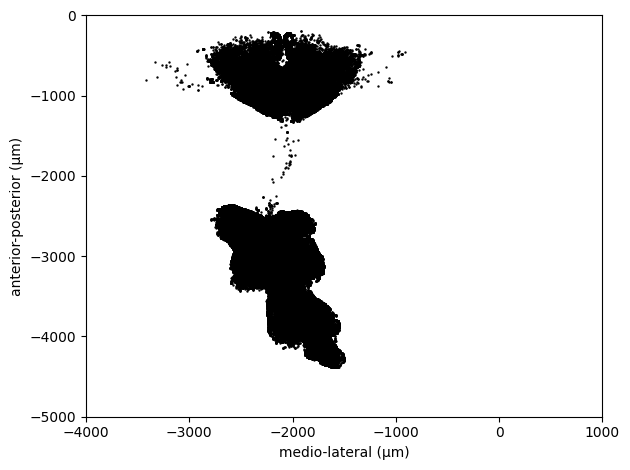

In [9]:
# Plot synapse positions in x-y plane in micrometers
fig, ax = plt.subplots()
ax.scatter(x/1000, y/1000, s=.5, color='k', alpha=1)
plt.xlabel('medio-lateral (µm)')
plt.ylabel('anterior-posterior (µm)')
ax.set(xlim=(-4000, 1000), ylim=(-5000, 0))
plt.tight_layout()
plt.show()

In [10]:
# Calculate fraction of output synapses below the neck across neurons
y_thresh = -2000 # Micrometers
np.sum(y <= y_thresh*1000) / len(y)

np.float64(0.6963582917822039)

In [11]:
# Calculate fraction of output synapses below the neck per neuron
y_thresh = -2000 # Micrometers
syn_fraction = []

for root_id in df_syn_filt.pre_pt_root_id.unique().tolist():
    voxel_size=[4.3,4.3,45]
    output_syn_pos = np.vstack(df_syn_filt.pre_pt_position[df_syn_filt.pre_pt_root_id==root_id].values)*voxel_size

    output_syn_pos[:,0] = -output_syn_pos[:,0]
    output_syn_pos[:,1] = -output_syn_pos[:,1]

    x = output_syn_pos[:,0]
    y = output_syn_pos[:,1]
    
    syn_fraction.append(np.sum(y <= y_thresh*1000) / len(y))

In [12]:
# Display mean fraction
np.mean(syn_fraction)

np.float64(0.6947653576128145)

In [13]:
# Display median fraction
np.median(syn_fraction)

np.float64(0.7526881720430108)

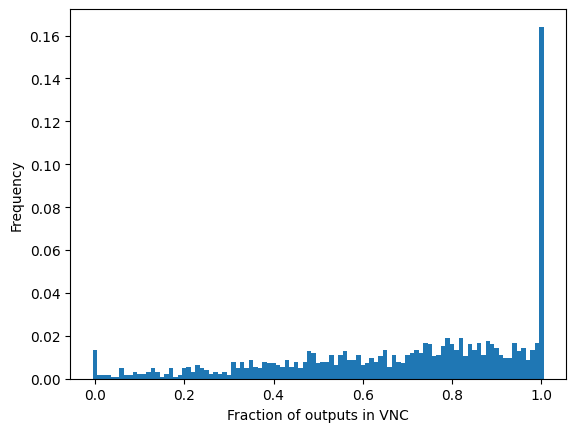

In [14]:
# Plot distribution 
binwidth = 0.01
plt.hist(syn_fraction, bins=np.arange(-binwidth/2, 1+binwidth/2+binwidth, binwidth), weights=np.ones_like(syn_fraction) / len(syn_fraction))
plt.xlabel('Fraction of outputs in VNC')
plt.ylabel('Frequency')
plt.show()